## 实验代码

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
from collections import Counter
from numpy import log, ones,zeros
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = "svg"

In [91]:
sms = pd.read_csv('./SMSSpamCollection', sep='\t', header=None)
sms.head

<bound method NDFrame.head of          0                                                  1
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [2]:
def textParse(bigString):
    """
    将字符串根据非(字母和数字字符)划分
    :param bigString: 待分割的字符串
    :return: 分割后的小写字符列表，该函数用于数据预处理
    如输入'hi, My name is Chen.. Bye',输出['hi', 'my', 'name', 'is', 'chen', 'bye']
    """
    import re
    listOfTokens = re.split('\W', bigString) # 正则表达式，只匹配数字和字母
    return [tok.lower() for tok in listOfTokens if len(tok) > 0]

In [3]:
def load_data_and_split(data_path:str, val_rate:float):
    """
    加载数据集并划分训练集和验证集
    :param data_path: 数据集路径
    :param val_rate: 验证集比例
    :return: 训练集列表，验证集列表，训练集标签列表，验证集标签列表
    """
    sms = pd.read_csv(data_path, sep='\t', header=None)
    data_lines = sms.loc[:,1].values.tolist()
    label_list = sms.loc[:,0].values.tolist()
    data_list = []
    for data_line in data_lines:
        data_line = textParse(data_line)
        data_list.append(data_line)
    train_data, val_data, train_label, val_label = train_test_split(data_list, label_list, test_size=val_rate, 
                                                                        random_state=random.randint(0,1000),shuffle=True)
    return train_data,val_data, train_label,val_label

In [4]:
def wrods2Vec(dataSet):
    """
    计算数据集中各个词出现的概率，概率使用拉普拉斯平滑
    :param dataSet: 待统计的数据集
    :return: 词概率字典，字典的键为字符，值为该字符出现在数据出现的概率
    如['a','b','a'], 返回{'a': 0.6, 'b': 0.4}
    """
    words2VecList = {}
    length = 0
    for data_line in dataSet:
        length += len(data_line)
        for word in data_line:
            if word in words2VecList:
                words2VecList[word] += 1
            else:
                words2VecList[word] = 1
    wordsSum = np.sum(list(words2VecList.values()))
    for key, value in words2VecList.items():
        words2VecList[key] = (value+1) / (wordsSum+2)
    return words2VecList

In [158]:
print(wrods2Vec(['a','b','a']))

{'a': 0.6, 'b': 0.4}


In [5]:
def word2VecWithLable(dataSet, labels):
    """
    计算数据集中每个标签类别下各个词出现的概率
    :param dataSet: 待统计的数据集。数据集为二维列表
    :param labels:  数据集对应的标签集合。
    :return: 
        1. 词频字典，字典的键为标签，值为数据集中属于该标签的数据个数
        2. 词概率字典，字典的键为标签，值为属于该标签的数据集合各个词出现的概率
    如输入([['a','a','b'],['a','b']],['spam','ham'])返回
        1. Counter({'spam': 1, 'ham': 1})
        2. {'ham': {'a': 0.5, 'b': 0.5}, 'spam': {'a': 0.6, 'b': 0.4}}
    """
    lableSet = set(labels)
    word2VecWithLableList = {}
    labelCount = Counter(labels)
    for lable in lableSet:
        subSet = []
        for i in range(len(labels)):
            if lable == labels[i]:
                subSet.append(dataSet[i])
        word2VecWithLableList[lable] = wrods2Vec(subSet)
    return labelCount,word2VecWithLableList

In [159]:
word2VecWithLable([['a','a','b'],['a','b']],['spam','ham'])

(Counter({'spam': 1, 'ham': 1}),
 {'ham': {'a': 0.5, 'b': 0.5}, 'spam': {'a': 0.6, 'b': 0.4}})

In [46]:
labelCount,word2VecWithLableList = word2VecWithLable(train_data, train_label)

In [7]:
def classifyNB(labelCount,word2VecWithLableList,words):
    """
    根据训练好的模型，预测输入向量的类型
    :param labelCount,word2VecWithLableList:word2VecWithLable(dataSet, labels)返回的结果
    :param words: 待预测的句子
    输出为预测类别
    """
    words = set(words)
    lableList = list(word2VecWithLableList.keys())
    probaList = []
    for lable in lableList:
        proba = 0.0
        word2VecList = word2VecWithLableList[lable]
        for word in words:
            if word in word2VecList:
                proba += log(word2VecList[word])
            else:
                proba += log(1/(labelCount[lable]+2500000))
        lablePro = labelCount[lable] / np.sum(list(labelCount.values()))
        probaList.append(proba + log(lablePro))
    return lableList[np.argmax(probaList)]

In [73]:
def getAccuracyWithM(train_data,train_label,val_data, val_label):
    """
    训练模型，预测验证集, 返回准确率
    """
    labelCount,word2VecWithLableList = word2VecWithLable(train_data,train_label)
    acc = 0
    for i in range(len(val_data)):
        predict = classifyNB(labelCount,word2VecWithLableList,val_data[i])
        if predict== val_label[i]:
            acc += 1
    return round((acc / len(val_data) * 100), 4)

In [101]:
# 进行多次测试
def testMultiTimes(times):
    val_acc_list = []
    time_list = [i+1 for i in range(times)]
    for i in range(times):
        train_data, val_data, train_label, val_label = load_data_and_split('./SMSSpamCollection',0.2)
        acc = getAccuracyWithM(train_data,train_label,val_data, val_label)
        val_acc_list.append(round(acc, 3))
    return time_list,val_acc_list

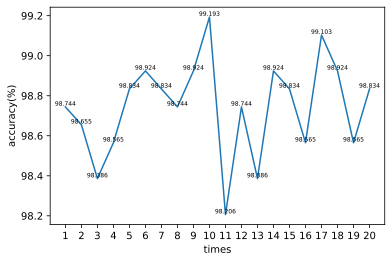

In [106]:
# 结果可视化
time_list,val_acc_list = testMultiTimes(20)
fig, aix = plt.subplots()
aix.plot(time_list,val_acc_list,label = 'validate_acc') # 训练集折线图
plt.xticks(time_list) # 设置x轴刻度
plt.xlabel("times") # 设置x轴标签
plt.ylabel("accuracy(%)") # 设置y轴标签
# 将数字标记在折线上方
for a, b in zip(time_list, val_acc_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=6)
plt.savefig("mutiTimesTest_My.svg", dpi=500,format="svg") # 保留图片

In [92]:
train_data, val_data, train_label, val_label = load_data_and_split('./SMSSpamCollection',0.2)
print(getAccuracyWithM(train_data,train_label,val_data, val_label))

98.6547


## 模型对比（实验模型与学长模型）

In [150]:
# 进行多次测试
def testMultiTimes2(times):
    m_acc_list, g_acc_list = [],[] # 实验模型准确率、学长模型准确率
    rate_list = [] # 实验模型运行时间与学长模型运行时间的比值
    time_list = [i+1 for i in range(times)]
    for i in range(times):
        train_data, val_data, train_label, val_label = load_data_and_split('./SMSSpamCollection',0.2)
        
        start =  time() # 开始计时
        m_acc = getAccuracyWithM(train_data,train_label,val_data, val_label) # 计算实验模型准确率
        m_time = time()-start # 停止计时，计算时间差值
        
        start =  time() # 开始计时
        g_acc = getAccuracyWithG(train_data, val_data, train_label, val_label)
        g_time = time()-start # 停止计时，计算时间差值
        
        m_acc_list.append(round(m_acc,3)) #保留3位小数
        g_acc_list.append(round(g_acc,3))
        rate_list.append(round((m_time/g_time)*100, 4)) #计算运行时间比，百分制且保留3位小数
    return time_list,m_acc_list, g_acc_list, rate_list

In [153]:
time_list,m_acc_list, g_acc_list, rate_list = testMultiTimes2(10)

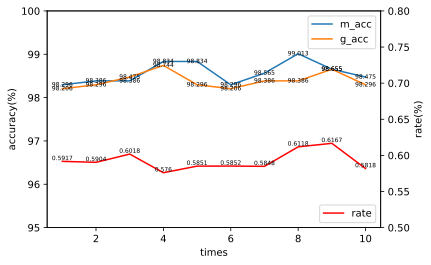

In [154]:
# 结果可视化
fig, ax1 = plt.subplots()
ax1.plot(time_list,m_acc_list,label = 'm_acc') # 实验模型准确率折线图
ax1.plot(time_list,g_acc_list,label = 'g_acc') # 学长模型准确率折线图
ax1.set_xlabel('times') # x轴标签
ax1.set_ylabel('accuracy(%)') # y轴标签
ax1.set_ylim(95,100) # 限制y轴范围
ax1.legend(loc=1) # 添加图例
# 在图中显示数据
for a, b in zip(time_list, m_acc_list):
    ax1.text(a, b, b, ha='center', va='center', fontsize=6) 
for a, b in zip(time_list, g_acc_list):
    ax1.text(a, b, b, ha='center', va='center', fontsize=6)
# 绘制双坐标图
ax2=ax1.twinx()
ax2.plot(time_list, rate_list, c='r',label='rate') # 折线图
ax2.set_ylabel('rate(%)')
ax2.set_ylim(0.5,0.8) # 限制y轴范围
ax2.legend(loc=4) # 添加图例
for a, b in zip(time_list, rate_list):
    ax2.text(a, b, b, ha='center', va='bottom', fontsize=6) # 在图中显示数据

plt.savefig("MyVsGt.svg", dpi=500,format="svg") # 保存图片

## 模型对比（实验模型、学长模型以及调包）

In [140]:
def testMultiTimes3(times):
    m_acc_list, g_acc_list, b_acc_list= [],[],[] # 实验模型准确率、学长模型准确率
    rate_list = [] # 实验模型运行时间与学长模型运行时间的比值
    time_list = [i+1 for i in range(times)]
    for i in range(times):
        x_train,x_test,y_train,y_test = load_data_and_splity()
        train_data,val_data,train_label, val_label = trans_data(x_train,x_test,y_train,y_test)
        
        start =  time() # 开始计时
        m_acc = getAccuracyWithM(train_data,train_label,val_data, val_label) # 计算实验模型准确率
        m_time = time()-start # 停止计时，计算时间差值
        
        start =  time() # 开始计时
        g_acc = getAccuracyWithG(train_data, val_data, train_label, val_label)
        g_time = time()-start # 停止计时，计算时间差值
        
        start =  time() # 开始计时
        b_acc = getAccuracyWithB(x_train,x_test,y_train,y_test)
        b_time = time()-start # 停止计时，计算时间差值
        
        m_acc_list.append(round(m_acc,3)) #保留3位小数
        g_acc_list.append(round(g_acc,3))
        b_acc_list.append(round(b_acc,3))
        rate_list.append(round((m_time/b_time)*100, 4)) #计算运行时间比，百分制且保留3位小数
    return time_list,m_acc_list, g_acc_list, b_acc_list, rate_list

In [155]:
time_list,m_acc_list, g_acc_list, b_acc_list, rate_list = testMultiTimes3(10)

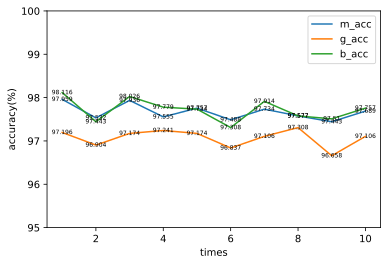

In [156]:
fig, ax1 = plt.subplots()
ax1.plot(time_list,m_acc_list,label = 'm_acc') # 实验模型准确率折线图
ax1.plot(time_list,g_acc_list,label = 'g_acc') # 学长模型准确率折线图
ax1.plot(time_list,b_acc_list,label = 'b_acc') # 多项式贝叶斯模型准确率折线图
ax1.set_xlabel('times') # x轴标签
ax1.set_ylabel('accuracy(%)') # y轴标签
ax1.set_ylim(95,100) # 限制y轴范围
ax1.legend(loc=1) # 添加图例
# 在图中显示数据
for a, b in zip(time_list, m_acc_list):
    ax1.text(a, b, b, ha='center', va='center', fontsize=6) 
for a, b in zip(time_list, g_acc_list):
    ax1.text(a, b, b, ha='center', va='center', fontsize=6)
for a, b in zip(time_list, b_acc_list):
    ax1.text(a, b, b, ha='center', va='center', fontsize=6)
# # 绘制双坐标图
# ax2=ax1.twinx()
# ax2.plot(time_list, rate_list, c='r',label='rate') # 折线图
# ax2.set_ylabel('rate(%)')
# ax2.set_ylim(375,400) # 限制y轴范围
# ax2.legend(loc=4) # 添加图例
# for a, b in zip(time_list, rate_list):
#     ax2.text(a, b, b, ha='center', va='bottom', fontsize=6) # 在图中显示数据

plt.savefig("MyVsGtVsBt.svg", dpi=800,format="svg") # 保存图片

## 学长代码

In [8]:
def creatVocabList(Data):
    List = set([])  # 创建一个空集合
    for document in Data:
        List = List | set(document)  # 对两个集合求并集
    return list(List)

In [9]:
def dataToVec(vocabList, inputSet):
    returnVec = [0] * len(vocabList)
    for word in inputSet:
        if word in vocabList:
            returnVec[vocabList.index(word)] += 1
    return returnVec

In [10]:
def naiveBayesTrain(trainData, trainLabel):
    N = len(trainData)
    NWords = len(trainData[0])
    pAbusive = Counter(trainLabel)['spam']/N
    p0Num = ones(NWords)
    p1Num = ones(NWords)  # Laplace平滑
    p0Denom = 2.0
    p1Denom = 2.0
    for i in range(N):
        if trainLabel[i] == 'spam':
            p1Num += trainData[i]
            p1Denom += sum(trainData[i])
        else:
            p0Num += trainData[i]
            p0Denom += sum(trainData[i])
    p1Vect = log(p1Num / p1Denom)
    p0Vect = log(p0Num / p0Denom)

    return p0Vect, p1Vect, pAbusive

In [11]:
def naiveBayesClf(testVec, p0Vec, p1Vec, pClass1):
    p1 = sum(testVec * p1Vec) + log(pClass1)  # element-wise mult
    p0 = sum(testVec * p0Vec) + log(1.0 - pClass1)
    if p1 > p0:
        return 'spam'
    else:
        return 'ham'

In [72]:
def getAccuracyWithG(train_data, val_data, train_label, val_label):
    data_list = creatVocabList(train_data)
    train_matrix = []
    for data in train_data:
        train_matrix.append(dataToVec(data_list,data))
    p0Vect, p1Vect, pAbusive = naiveBayesTrain(train_matrix,train_label)
    acc = 0.0
    for i in range(len(val_data)):
        val_list = dataToVec(data_list, val_data[i])
        if naiveBayesClf(val_list,p0Vect, p1Vect, pAbusive) == val_label[i]:
            acc += 1
    return round((acc/len(val_data)*100),4)

In [13]:
train_data, val_data, train_label, val_label = load_data_and_split('./SMSSpamCollection',0.2)
from time import time
start = time()
print(getAccuracyWithG(train_data, val_data, train_label, val_label))
print((time()-start)*1000)

98.8341
13185.959577560425
98.9238
78.0191421508789


In [54]:
train_data, val_data, train_label, val_label = load_data_and_split('./SMSSpamCollection',0.2)
start = time()
print(getAccuracy(train_data,train_label,val_data, val_label))
print((time()-start)*1000)

98.6547
79.99920845031738


## 调包

In [80]:
def load_data_and_splity(data_path = './SMSSpamCollection', test_rate = 0.2):
    """
    加载数据集并划分训练集和验证集
    :param data_path: 数据集路径
    :param val_rate: 验证集比例
    :return: 训练集列表，验证集列表，训练集标签列表，验证集标签列表
    """
    Cnames=['labels','messages']
    data = pd.read_csv(path,sep='\t', header=None, names=Cnames)  #读取数据集，分隔符是\t
    data=data.replace({'ham':0,'spam':1})  #替换标签值
    X=data['messages']
    y=data['labels']
    x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=test_rate)
    return x_train,x_test,y_train,y_test

In [66]:
def trans_data(x_train,x_test,y_train,y_test):
    x_train_tp = x_train.values.tolist()
    x_test_tp  = x_test.values.tolist()
    train_label = y_train.replace({0:'ham',1:'spam'}).values.tolist() #'ham':0,'spam':1
    val_label =  y_test.replace({0:'ham',1:'spam'}).values.tolist() #'ham':0,'spam':1
    train_data = []
    val_data = []
    for data_line in x_train_tp:
        data_line = textParse(data_line)
        train_data.append(data_line)
    
    for data_line in x_test_tp:
        data_line = textParse(data_line)
        val_data.append(data_line)
    return train_data,val_data, train_label, val_label

In [76]:
def getAccuracyWithB(x_train,x_test,y_train,y_test):
    vector_pnb=CountVectorizer()
    train_matrix=vector_pnb.fit_transform(x_train)
    test_matrix=vector_pnb.transform(x_test)
    pnb=MultinomialNB()
    clm_pnb=pnb.fit(train_matrix, y_train)
    return round(clm_pnb.score(test_matrix, y_test)*100,4)

In [87]:
x_train,x_test,y_train,y_test = load_data_and_splity()
train_data,val_data,train_label, val_label = trans_data(x_train,x_test,y_train,y_test)

# 实验代码
start = time()
print(getAccuracyWithM(train_data,train_label,val_data, val_label))
print((time()-start)*1000)

# 多项式模型
start = time()
print(getAccuracyWithB(x_train,x_test,y_train,y_test))
print((time()-start)*1000)

# 学长代码
start = time()
print(getAccuracyWithG(train_data, val_data, train_label, val_label))
print((time()-start)*1000)

98.0933
241.30678176879883
98.0709
61.64073944091797
97.0839
8012.20178604126


In [14]:
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

## 实验测试集

In [235]:
train_data, val_data, train_label, val_label = load_data_and_split('./SMSSpamCollection',0.2)
print(getAccuracy(train_data,train_label,val_data, val_label))

98.296


## 20newsgroups

In [192]:
from sklearn.datasets import fetch_20newsgroups #导入模块
news_data = fetch_20newsgroups(subset="all") #读取数据

In [206]:
def load_data_and_splitx(news_data,val_rate=0.2):
    """
    加载数据集并划分训练集和验证集
    :param data_path: 数据集路径
    :param val_rate: 验证集比例
    :return: 训练集列表，验证集列表，训练集标签列表，验证集标签列表
    """
    data_lines = news_data.data
    label_list = news_data.target
    data_list = []
    for data_line in data_lines:
        data_line = textParse(data_line)
        data_list.append(data_line)
    train_data, val_data, train_label, val_label = train_test_split(data_list, label_list, test_size=val_rate, 
                                                                        random_state=random.randint(0,1000),shuffle=True)
    return train_data,val_data, train_label,val_label

In [227]:
train_data,val_data, train_label,val_label = load_data_and_splitx(news_data)
print(getAccuracy(train_data,train_label,val_data, val_label))

88.0371


## Iris.txt

In [236]:
def load_data_and_splity(data_path:str, val_rate:float):
    """
    加载数据集并划分训练集和验证集
    :param data_path: 数据集路径
    :param val_rate: 验证集比例
    :return: 训练集列表，验证集列表，训练集标签列表，验证集标签列表
    """
    with open(data_path,'r') as openfile:
        data_lines = openfile.read().splitlines()  # 读取文件的所有行，忽略换行符
    data_lines = list(set(data_lines))
    data_list,label_list = [],[]
    for data_line in data_lines:
        data_line = data_line.split(",")
        data_list.append(list(map(float,data_line[0:-1])))
        label_list.append(data_line[-1])
    train_data, val_data, train_label, val_label = train_test_split(data_list,\
                                                                    label_list,\
                                                                    test_size=val_rate,\
                                                                    random_state=random.randint(2,1000),\
                                                                    shuffle=True)
    return train_data, val_data, train_label, val_label

In [247]:
train_data, val_data, train_label, val_label = load_data_and_splity(data_path="./Iris.txt", val_rate=0.2)
print(getAccuracy(train_data,train_label,val_data, val_label))

86.6667
